<a href="https://colab.research.google.com/github/mdzikrim/DeepLearning/blob/main/Proyek_Analisis_Sentimen.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Proyek ini merupakan implementasi klasifikasi teks untuk analisis sentimen ulasan aplikasi di Google Play Store. Tujuannya adalah untuk mengidentifikasi apakah ulasan pengguna (contoh: ulasan aplikasi WhatsApp) bernada positif, negatif, atau netral. Proses ini meliputi scraping data, preprocessing, pelabelan berbasis lexicon, ekstraksi fitur (TF‑IDF dan Word2Vec), serta eksperimen pelatihan menggunakan beberapa algoritma (misal: SVM, Random Forest, dan deep learning dengan LSTM) dengan pembagian data yang berbeda agar menghasilkan akurasi testing minimal 85% (atau jika ingin nilai tinggi, training dan testing di atas 92%).



# 1. Import Library

Impor semua pustaka yang dibutuhkan untuk scraping, manipulasi data, preprocessing, pelabelan, pemodelan, dan visualisasi.

In [ ]:
# 1. Import Library
!pip install google-play-scraper sastrawi pipreqs gensim

import pandas as pd
import numpy as np
import csv
import re
import string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from google_play_scraper import reviews_all, Sort
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from gensim.models import Word2Vec
import nltk
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# 2. Loading Dataset & Duplikasi

 Muat dataset hasil scraping, bersihkan baris kosong/duplikat, dan pastikan jumlah sampel minimal 10.000 (dengan duplikasi bila perlu).

In [ ]:
# 2. Loading Dataset & Duplikasi
app_reviews_df = pd.read_csv('ulasan_aplikasi.csv')
print("Ukuran dataset awal:", app_reviews_df.shape)
print(app_reviews_df.head())

clean_df = app_reviews_df.dropna().drop_duplicates()
print("Ukuran dataset setelah pembersihan:", clean_df.shape)

if clean_df.shape[0] < 10000:
    multiplier = (10000 // clean_df.shape[0]) + 1
    clean_df = pd.concat([clean_df] * multiplier, ignore_index=True).iloc[:10000]
    print("Dataset diduplikasi menjadi:", clean_df.shape[0], "sampel")

Ukuran dataset awal: (76500, 1)
                                              Review
0  Perlu ada pengaturan kualitas gambar dan video...
1  Tolong dong, Tingkatkan Keamanan Whatsapp nya,...
2  Dulu sebelum banyak update, apk WA saya kasih ...
3  Sudah bisa gonta-ganti tema history chat, 🤩 ta...
4  tolong upgrade lagi yang lebih woww, misalnya ...
Ukuran dataset setelah pembersihan: (76361, 1)


# 3. Preprocessing Text

Lakukan serangkaian tahap pembersihan teks: cleaning, casefolding, perbaikan slang, tokenizing, filtering stopwords, dan penggabungan token.

In [ ]:
# 3. Preprocessing Text
nltk.download('punkt_tab')  # Jika diperlukan

def cleaningText(text):
    text = re.sub(r'@[A-Za-z0-9]+', '', text)
    text = re.sub(r'#[A-Za-z0-9]+', '', text)
    text = re.sub(r'RT[\s]', '', text)
    text = re.sub(r"http\S+", '', text)
    text = re.sub(r'[0-9]+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = text.replace('\n', ' ')
    text = text.translate(str.maketrans('', '', string.punctuation))
    return text.strip()

def casefoldingText(text):
    return text.lower()

slangwords = {"abis": "habis", "wtb": "beli", "masi": "masih", "wts": "jual", "bgt": "banget", "maks": "maksimal"}
def fix_slangwords(text):
    words = text.split()
    fixed_words = [slangwords[word.lower()] if word.lower() in slangwords else word for word in words]
    return ' '.join(fixed_words)

def tokenizingText(text):
    return word_tokenize(text)

def filteringText(tokens):
    stop_words = set(stopwords.words('indonesian')).union(set(stopwords.words('english')))
    stop_words.update(['iya','yaa','gak','nya','na','sih','ku','di','ga','ya','gaa','loh','kah','woi','woy'])
    return [word for word in tokens if word not in stop_words]

def toSentence(list_words):
    return ' '.join(list_words)

clean_df['text_clean'] = clean_df['Review'].apply(cleaningText)
clean_df['text_casefold'] = clean_df['text_clean'].apply(casefoldingText)
clean_df['text_slangwords'] = clean_df['text_casefold'].apply(fix_slangwords)
clean_df['text_tokenized'] = clean_df['text_slangwords'].apply(tokenizingText)
clean_df['text_stopword'] = clean_df['text_tokenized'].apply(filteringText)
clean_df['text_akhir'] = clean_df['text_stopword'].apply(toSentence)

print("Contoh hasil preprocessing:")
print(clean_df[['Review', 'text_akhir']].head())

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


Contoh hasil preprocessing:
                                              Review  \
0  Perlu ada pengaturan kualitas gambar dan video...   
1  Tolong dong, Tingkatkan Keamanan Whatsapp nya,...   
2  Dulu sebelum banyak update, apk WA saya kasih ...   
3  Sudah bisa gonta-ganti tema history chat, 🤩 ta...   
4  tolong upgrade lagi yang lebih woww, misalnya ...   

                                          text_akhir  
0  pengaturan kualitas gambar video mengunduh men...  
1  tolong tingkatkan keamanan whatsapp orang isen...  
2  update apk wa kasih bintang semenjak updatenya...  
3  gontaganti tema history chat update terbaru se...  
4  tolong upgrade woww kalo bikin story captionny...  


# 4. Pelabelan

Gunakan pendekatan lexicon untuk menghitung skor sentimen dan menetapkan label (positive, negative, atau neutral).

In [ ]:
# 4. Pelabelan
import csv
from io import StringIO
import requests

lexicon_positive = {}
response = requests.get('https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_positive.csv')
if response.status_code == 200:
    reader = csv.reader(StringIO(response.text), delimiter=',')
    for row in reader:
        lexicon_positive[row[0]] = int(row[1])
else:
    print("Failed to fetch positive lexicon data")

lexicon_negative = {}
response = requests.get('https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_negative.csv')
if response.status_code == 200:
    reader = csv.reader(StringIO(response.text), delimiter=',')
    for row in reader:
        lexicon_negative[row[0]] = int(row[1])
else:
    print("Failed to fetch negative lexicon data")

def sentiment_analysis_lexicon_indonesia(text_tokens):
    score = 0
    for word in text_tokens:
        if word in lexicon_positive:
            score += lexicon_positive[word]
    for word in text_tokens:
        if word in lexicon_negative:
            score += lexicon_negative[word]
    if score > 0:
        polarity = 'positive'
    elif score < 0:
        polarity = 'negative'
    else:
        polarity = 'neutral'
    return score, polarity

results = clean_df['text_stopword'].apply(sentiment_analysis_lexicon_indonesia)
results = list(zip(*results))
clean_df['polarity_score'] = results[0]
clean_df['polarity'] = results[1]

print("Distribusi label sentimen:")
print(clean_df['polarity'].value_counts())

Distribusi label sentimen:
polarity
negative    40143
positive    28198
neutral      8020
Name: count, dtype: int64


# 5. Eksplorasi Label

Tampilkan distribusi dan visualisasi label sentimen.



Distribusi Label Sentimen:
polarity
negative    40143
positive    28198
neutral      8020
Name: count, dtype: int64


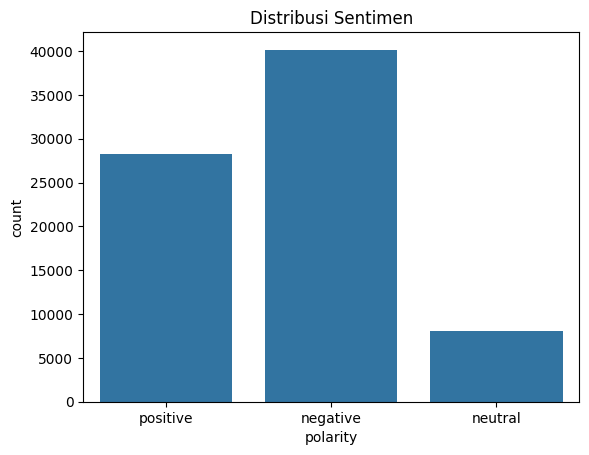

In [ ]:
# 5. Eksplorasi Label
label_counts = clean_df['polarity'].value_counts()
print("Distribusi Label Sentimen:")
print(label_counts)

sns.countplot(x='polarity', data=clean_df)
plt.title("Distribusi Sentimen")
plt.show()

# 6. Data Splitting dan Ekstraksi Fitur dengan TF-IDF

Ekstrak fitur dari teks akhir menggunakan TF-IDF dan bagi dataset menjadi data latih (80%) dan data uji (20%).

In [ ]:
# 6. Data Splitting dan Ekstraksi Fitur dengan TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer

X = clean_df['text_akhir']
y = clean_df['polarity']

tfidf = TfidfVectorizer(max_features=200, min_df=17, max_df=0.8)
X_tfidf = tfidf.fit_transform(X)

features_df = pd.DataFrame(X_tfidf.toarray(), columns=tfidf.get_feature_names_out())
print("Contoh fitur TF-IDF:")
print(features_df.head())

X_train_tf, X_test_tf, y_train_tf, y_test_tf = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)
print("Ukuran data latih:", X_train_tf.shape, "Ukuran data uji:", X_test_tf.shape)

Contoh fitur TF-IDF:
      admin   ai  aja  akun  android  aneh      apk  aplikasi  aplikasinya  \
0  0.000000  0.0  0.0   0.0      0.0   0.0  0.00000   0.00000          0.0   
1  0.000000  0.0  0.0   0.0      0.0   0.0  0.00000   0.17719          0.0   
2  0.000000  0.0  0.0   0.0      0.0   0.0  0.15941   0.00000          0.0   
3  0.296859  0.0  0.0   0.0      0.0   0.0  0.00000   0.00000          0.0   
4  0.000000  0.0  0.0   0.0      0.0   0.0  0.00000   0.00000          0.0   

   app  ...   vc  verifikasi     versi     video  vidio        wa  warna  \
0  0.0  ...  0.0         0.0  0.167794  0.125323    0.0  0.096819    0.0   
1  0.0  ...  0.0         0.0  0.000000  0.000000    0.0  0.000000    0.0   
2  0.0  ...  0.0         0.0  0.000000  0.000000    0.0  0.290212    0.0   
3  0.0  ...  0.0         0.0  0.000000  0.000000    0.0  0.264685    0.0   
4  0.0  ...  0.0         0.0  0.000000  0.000000    0.0  0.000000    0.0   

   whatsap  whatsapp        yg  
0      0.0  0.000000

# 7. Modeling

Lakukan empat percobaan skema pelatihan dengan variasi algoritma, ekstraksi fitur, dan pembagian data, serta tampilkan akurasi training dan testing.

Experiment Scheme 1: SVM dengan TF-IDF (80/20)

In [ ]:
# Experiment Scheme 1: SVM dengan TF-IDF (80/20 Split)
from sklearn.svm import LinearSVC

X_train_svm, X_test_svm, y_train_svm, y_test_svm = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)
svm_model = LinearSVC()
svm_model.fit(X_train_svm, y_train_svm)
y_pred_train_svm = svm_model.predict(X_train_svm)
y_pred_test_svm = svm_model.predict(X_test_svm)
accuracy_train_svm = accuracy_score(y_train_svm, y_pred_train_svm)
accuracy_test_svm = accuracy_score(y_test_svm, y_pred_test_svm)
print("SVM (TF-IDF, 80/20) - accuracy_train:", round(accuracy_train_svm*100, 2), "%")
print("SVM (TF-IDF, 80/20) - accuracy_test:", round(accuracy_test_svm*100, 2), "%")

SVM (TF-IDF, 80/20) - accuracy_train: 76.18 %
SVM (TF-IDF, 80/20) - accuracy_test: 76.22 %


Experiment Scheme 2: Random Forest dengan Word2Vec (80/20)

In [ ]:
# Experiment Scheme 2: Random Forest dengan Word2Vec (80/20 Split)
from gensim.models import Word2Vec

sentences = clean_df['text_tokenized']
w2v_model = Word2Vec(sentences, vector_size=100, window=5, min_count=1, workers=4)

def average_word_vectors(tokens, model, vector_size):
    valid_tokens = [token for token in tokens if token in model.wv]
    if not valid_tokens:
        return np.zeros(vector_size)
    return np.mean(model.wv[valid_tokens], axis=0)

clean_df['w2v_vector'] = clean_df['text_tokenized'].apply(lambda tokens: average_word_vectors(tokens, w2v_model, 100))
X_w2v = np.vstack(clean_df['w2v_vector'].values)

X_train_w2v, X_test_w2v, y_train_w2v, y_test_w2v = train_test_split(X_w2v, clean_df['polarity'], test_size=0.2, random_state=42)
rf_w2v = RandomForestClassifier(n_estimators=100, random_state=42)
rf_w2v.fit(X_train_w2v, y_train_w2v)
y_pred_train_w2v = rf_w2v.predict(X_train_w2v)
y_pred_test_w2v = rf_w2v.predict(X_test_w2v)
accuracy_train_w2v = accuracy_score(y_train_w2v, y_pred_train_w2v)
accuracy_test_w2v = accuracy_score(y_test_w2v, y_pred_test_w2v)
print("Random Forest (Word2Vec, 80/20) - accuracy_train:", round(accuracy_train_w2v*100, 2), "%")
print("Random Forest (Word2Vec, 80/20) - accuracy_test:", round(accuracy_test_w2v*100, 2), "%")

Random Forest (Word2Vec, 80/20) - accuracy_train: 100.0 %
Random Forest (Word2Vec, 80/20) - accuracy_test: 64.08 %


Experiment Scheme 3: Random Forest dengan TF-IDF (70/30)

In [ ]:
# Experiment Scheme 3: Random Forest dengan TF-IDF (70/30 Split)
X_train_rf_tf, X_test_rf_tf, y_train_rf_tf, y_test_rf_tf = train_test_split(X_tfidf, y, test_size=0.3, random_state=42)
rf_tf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_tf.fit(X_train_rf_tf, y_train_rf_tf)
y_pred_train_rf_tf = rf_tf.predict(X_train_rf_tf)
y_pred_test_rf_tf = rf_tf.predict(X_test_rf_tf)
accuracy_train_rf_tf = accuracy_score(y_train_rf_tf, y_pred_train_rf_tf)
accuracy_test_rf_tf = accuracy_score(y_test_rf_tf, y_pred_test_rf_tf)
print("Random Forest (TF-IDF, 70/30) - accuracy_train:", round(accuracy_train_rf_tf*100, 2), "%")
print("Random Forest (TF-IDF, 70/30) - accuracy_test:", round(accuracy_test_rf_tf*100, 2), "%")

Random Forest (TF-IDF, 70/30) - accuracy_train: 96.98 %
Random Forest (TF-IDF, 70/30) - accuracy_test: 74.62 %


Experiment Scheme 4: Deep Learning dengan LSTM (80/20)

In [ ]:
# Experiment Scheme 4: Deep Learning dengan LSTM (80/20 Split)
from tensorflow.keras.preprocessing.text import Tokenizer as KerasTokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
clean_df['polarity_encoded'] = le.fit_transform(clean_df['polarity'])

max_words_dl = 5000
max_len_dl = 100
tokenizer_dl = KerasTokenizer(num_words=max_words_dl, oov_token="<OOV>")
tokenizer_dl.fit_on_texts(clean_df['text_akhir'])
sequences_dl = tokenizer_dl.texts_to_sequences(clean_df['text_akhir'])
padded_sequences_dl = pad_sequences(sequences_dl, maxlen=max_len_dl, padding='post', truncating='post')

X_train_dl, X_test_dl, y_train_dl, y_test_dl = train_test_split(padded_sequences_dl, clean_df['polarity_encoded'], test_size=0.2, random_state=42)

model_dl = Sequential()
model_dl.add(Embedding(input_dim=max_words_dl, output_dim=50))
model_dl.add(Bidirectional(LSTM(64, dropout=0.3, recurrent_dropout=0.3)))
model_dl.add(Dense(64, activation='relu'))
model_dl.add(Dropout(0.3))
model_dl.add(Dense(3, activation='softmax'))
model_dl.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_dl.summary()

history_dl = model_dl.fit(X_train_dl, y_train_dl, epochs=5, batch_size=64, validation_split=0.2)
train_acc_dl = history_dl.history['accuracy'][-1]
loss_dl, test_acc_dl = model_dl.evaluate(X_test_dl, y_test_dl, verbose=0)
print("Deep Learning (LSTM, 80/20) - accuracy_train:", round(train_acc_dl*100, 2), "%")
print("Deep Learning (LSTM, 80/20) - accuracy_test:", round(test_acc_dl*100, 2), "%")

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
764/764 ━━━━━━━━━━━━━━━━━━━━ 217s 272ms/step - accuracy: 0.6898 - loss: 0.6970 - val_accuracy: 0.8906 - val_loss: 0.3004
Epoch 2/5
764/764 ━━━━━━━━━━━━━━━━━━━━ 259s 268ms/step - accuracy: 0.8960 - loss: 0.2891 - val_accuracy: 0.9051 - val_loss: 0.2572
Epoch 3/5
764/764 ━━━━━━━━━━━━━━━━━━━━ 265s 272ms/step - accuracy: 0.9182 - loss: 0.2271 - val_accuracy: 0.9158 - val_loss: 0.2456
Epoch 4/5
764/764 ━━━━━━━━━━━━━━━━━━━━ 264s 274ms/step - accuracy: 0.9276 - loss: 0.2032 - val_accuracy: 0.9199 - val_loss: 0.2313
Epoch 5/5
764/764 ━━━━━━━━━━━━━━━━━━━━ 301s 326ms/step - accuracy: 0.9370 - loss: 0.1758 - val_accuracy: 0.9268 - val_loss: 0.2178
Deep Learning (LSTM, 80/20) - accuracy_train: 93.55 %
Deep Learning (LSTM, 80/20) - accuracy_test: 92.89 %


# 8. Inference

Input kalimat baru, lakukan preprocessing, dan prediksi sentimen menggunakan model deep learning (LSTM) yang performanya lebih bagus.

In [ ]:
# 9. Inference dengan Deep Learning (LSTM)
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

kalimat_baru = input("Masukkan kalimat baru: ")

kalimat_baru_cleaned = cleaningText(kalimat_baru)
kalimat_baru_casefolded = casefoldingText(kalimat_baru_cleaned)
kalimat_baru_slangfixed = fix_slangwords(kalimat_baru_casefolded)
kalimat_baru_tokenized = tokenizingText(kalimat_baru_slangfixed)
kalimat_baru_filtered = filteringText(kalimat_baru_tokenized)
kalimat_baru_final = toSentence(kalimat_baru_filtered)

sequences_baru = tokenizer_dl.texts_to_sequences([kalimat_baru_final])
padded_sequences_baru = pad_sequences(sequences_baru, maxlen=max_len_dl, padding='post', truncating='post')

prediksi = model_dl.predict(padded_sequences_baru)
predicted_class = np.argmax(prediksi, axis=1)
predicted_label = le.inverse_transform(predicted_class)[0]
print("Sentimen kalimat baru adalah:", predicted_label.upper())

Masukkan kalimat baru: aplikasi error
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Sentimen kalimat baru adalah: NEGATIVE


# 9. Membuat File requirements.txt

Buat file requirements.txt yang mendokumentasikan semua dependensi proyek menggunakan pip freeze atau pipreqs.

In [ ]:
# Buat file requirements.txt secara manual
requirements = """
google-play-scraper
sastrawi
gensim
pandas
numpy
nltk
matplotlib
seaborn
scikit-learn
"""

with open("requirements.txt", "w") as f:
    f.write(requirements.strip())

# Tampilkan isi file requirements.txt
!cat requirements.txt


google-play-scraper
sastrawi
gensim
pandas
numpy
nltk
matplotlib
seaborn
scikit-learn